<a href="https://colab.research.google.com/github/Sisipho-Hamlomo/Decision-tree/blob/main/LLRMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from skimage import io, util, color
from numpy.linalg import svd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def patch_distance(patch1, patch2):
    """Calculate the squared Euclidean distance between two patches."""
    return np.sum((patch1 - patch2) ** 2)


In [ ]:
def calculate_weights(image, patch_size, search_window, h):
    """Calculate weights for Non-Local Means denoising."""
    height, width = image.shape
    weights = np.zeros((height, width, height, width))
    for i in range(height):
        for j in range(width):
            patch_i = image[max(i - patch_size // 2, 0):min(i + patch_size // 2 + 1, height),
                             max(j - patch_size // 2, 0):min(j + patch_size // 2 + 1, width)]
            for m in range(max(i - search_window // 2, 0), min(i + search_window // 2 + 1, height)):
                for n in range(max(j - search_window // 2, 0), min(j + search_window // 2 + 1, width)):
                    patch_m = image[max(m - patch_size // 2, 0):min(m + patch_size // 2 + 1, height),
                                     max(n - patch_size // 2, 0):min(n + patch_size // 2 + 1, width)]
                    if patch_i.shape != patch_m.shape:
                        continue
                    weights[i, j, m, n] = np.exp(-np.sum((patch_i - patch_m) ** 2) / (h ** 2))
    return weights


In [ ]:
def svd_denoise(patch, threshold):
    """Perform Singular Value Decomposition (SVD) denoising on a patch."""
    U, s, Vt = np.linalg.svd(patch)
    s_thresholded = np.maximum(s - threshold, 0)
    reconstructed_patch = np.dot(U[:, :len(s_thresholded)] * s_thresholded, Vt)
    return reconstructed_patch

In [ ]:
def nlm_denoise(image, weights, patch_size, search_window, h, svd_threshold):
    """Perform Non-Local Means denoising on the image."""
    height, width = image.shape
    denoised_image = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            denoised_patch_sum = np.zeros((patch_size, patch_size))  # Initialize sum of denoised patches
            total_weight = 0  # Initialize total weight

            for m in range(max(i - search_window // 2, 0), min(i + search_window // 2 + 1, height)):
                for n in range(max(j - search_window // 2, 0), min(j + search_window // 2 + 1, width)):
                    patch_m = image[max(m - patch_size // 2, 0):min(m + patch_size // 2 + 1, height),
                                    max(n - patch_size // 2, 0):min(n + patch_size // 2 + 1, width)]
                    #print("patch_m shape:", patch_m.shape)
                    if patch_m.shape != (patch_size, patch_size):
                        continue
                    weight = weights[i, j, m, n]  # Get weight from precalculated weights
                    #print("weight:", weight)
                    denoised_patch = svd_denoise(patch_m, svd_threshold)
                    #print("denoised_patch shape:", denoised_patch.shape)
                    denoised_patch_sum += weight * denoised_patch  # Accumulate denoised patches
                    total_weight += weight  # Accumulate total weight

            denoised_patch_sum /= total_weight  # Normalize denoised patches by total weight
            denoised_image[i, j] = np.sum(denoised_patch_sum) / total_weight  # Compute denoised pixel value

    return denoised_image

In [ ]:
# Load a noisy image
noisy_image = util.random_noise(io.imread('/content/drive/MyDrive/Y11.png'), var=0.1)

grayscale_noisy_image = color.rgb2gray(noisy_image)
# Calculate weights
weights = calculate_weights(grayscale_noisy_image, patch_size=8, search_window=11, h=0.1)

# Denoise the grayscale image
denoised_image = nlm_denoise(grayscale_noisy_image, weights, patch_size=8, search_window=11, h=0.1, svd_threshold=0.1)

<ipython-input-5-eb9d77da841d>:25: RuntimeWarning: invalid value encountered in divide
  denoised_patch_sum /= total_weight  # Normalize denoised patches by total weight


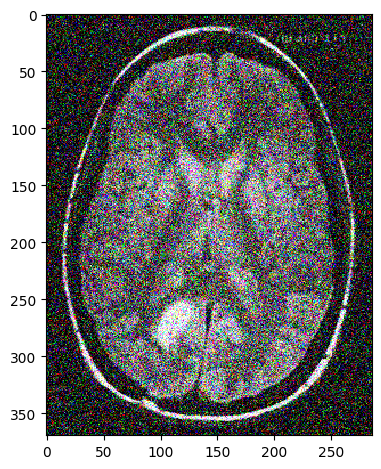

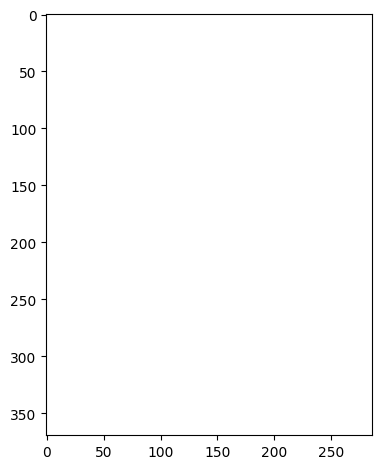

In [ ]:
# Calculate PSNR
mse = np.mean((denoised_image - grayscale_noisy_image)**2)
psnr = 20 * np.log10(1.0 / np.sqrt(mse))
# Display results
io.imshow(noisy_image)
io.show()

io.imshow(denoised_image)
io.show()

In [ ]:
print(mse)
print(psnr)

nan
nan


In [ ]:
import matplotlib.pyplot as plt

denoised_image.shape

(370, 286)